In [30]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv('./datasets/AMZN.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
dataset = dataset[['Date', 'Close']]
dataset.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


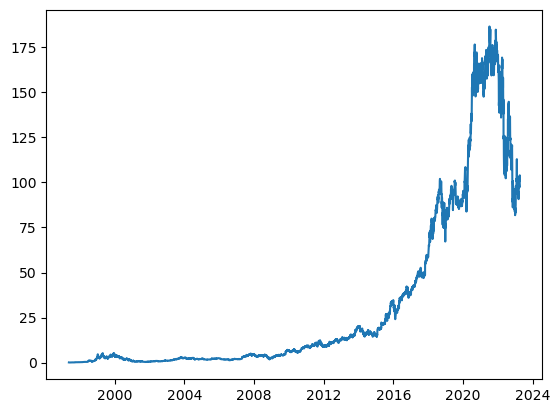

In [6]:
plt.plot(pd.to_datetime(dataset['Date']), dataset['Close'])

In [7]:
def prepare_dataset(dataset, n_steps):
    dataset.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        dataset[f"Close(t-{i})"] = dataset['Close'].shift(i)

    dataset.dropna(inplace=True)
    return dataset

look_back = 7
shifted_df = prepare_dataset(dataset, look_back)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [10]:
shifted_df_numpy = shifted_df.to_numpy()

scalar = MinMaxScaler(feature_range=(-1,1))
shifted_df_numpy = scalar.fit_transform((shifted_df_numpy))

shifted_df_numpy[:5]

array([[-0.99991063, -0.99995531, -1.        , -0.99998325, -0.99987154,
        -0.99983244, -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, -1.        , -0.99998325,
        -0.99987154, -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, -0.99994415, -1.        ,
        -0.99998325, -0.99987154, -0.99983244],
       [-0.99995531, -0.99995253, -0.99992739, -0.99989946, -0.99994415,
        -1.        , -0.99998325, -0.99987154],
       [-0.99994973, -0.99995531, -0.99994136, -0.99992739, -0.99989946,
        -0.99994415, -1.        , -0.99998325]])

In [12]:
X = shifted_df_numpy[:, 1:]
y = shifted_df_numpy[:, 0]
print(X[1] , y[1])
print(X.shape, y.shape)

[-0.99991063 -0.99994415 -1.         -0.99998325 -0.99987154 -0.99983244
 -0.99982128] -0.999938552167786
(6509, 7) (6509,)


In [13]:
X = np.flip(X, axis = 1)
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [14]:
split_index = int(len(X)*0.95)
split_index

6183

In [18]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [19]:
X_train = X_train.reshape((-1, look_back,1))
X_test = X_test.reshape((-1, look_back, 1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [28]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

C:\Users\hp\AppData\Local\Temp\ipykernel_3324\2122207645.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\hp\AppData\Local\Temp\ipykernel_3324\2122207645.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\hp\AppData\Local\Temp\ipykernel_3324\2122207645.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\hp\AppData\Local\Temp\ipykernel_3324\2122207645.py:4: UserWarning: To copy construct from 

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesData(Dataset):
    def __init__(self, X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = TimeSeriesData(X_train, y_train)
test_dataset = TimeSeriesData(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])
